# Replication Dynamic Flux Balance Analysis of Diauxic Growth in Escherichia coli

### Introduction
This project is based off of the papers *Dynamic Flux Balance Analysis of Diauxic Growth in Escherichia coli* by Mahadevan et al, and *A study of a diauxic growth experiment using an expanded dynamic flux balance framework* by Karlsen et al. The first paper developed the dynamic Flux Balance Analysis (dFBA) method to predict metabolic processes without needing full kinetic models. The second paper was a similar investigation into diauxic growth (the shift from utilizing glucose as a carbon source to utilizing acetate) of E. coli using dFBA and the same experimental conditions, but they included an additional set of constraints that will not be included in this paper. The original dFBA paper hypothesized that a Static Optimization Approach (SOA) where a steady state FBA is solved at discrete time steps while updating external constraints, would be sufficient to predict dynamic shifts in flux and metabolic profiles. The aim of this project is to replicate the SOA dFBA methodology described by Mahadevan et al. (and repeated in Karlsen et al.) and to analyze how well it compares to experimental fermentation data. 

### Background
Bacterial metabolism encompasses all the biochemical processes that occure within bacterial cells and generally can be described by the conversion of environmental nutrients into energy (ATP) and biomass precursors (amino acids, nucleotides, etc). These processes occur through a large set of enzyme-catalyzed reactions organized into a complex, interconnected biochemical network called the metabolic network. The complexity of this network provides redundancy, robustness and the ability to adapt to diverse environments through an interaction of gene regulation and kinetic processes. Although kinetics and regulation ultimately determine instantaneous metabolic behavior, much of the system maintains relatively stable intracellular concentrations. This quasi-steady state emerges because the kinetic processes are much faster than changes in teh enzyme levels. This quasi-steady state assumption is one of the foundations for constraint-based modeling. 

In addition to the time scale differences between regulation and reaction kinetics, metabolic networks are also defined by being mass-balanced stoichiometric systems. In other words, every reaction in the network obeys conservation of mass that can be defined by stoichiometric relationships between the substrates and products of each reaction. This principle imposes relationships between reaction rates where, for example, if a metabolite is produced twice as fast as it is consumed or excreted, that metabolite would accumulate within the cell. 

These two constrains, quasi-steady state and conservation of mass, lead to a relatively robust assumption that many growth conditions are balanced in that they satisfy the following condition:

$$\frac{d[X]}{dt} \approx 0$$

The above equation states that, under steady state conditions, the flux through each reaction is constant. The goal of constraint-based metabolic modeling is to predict which pathways carry flux and at what magnitudes given specific environmental conditions.

**Flux Balance Analysis (FBA)** is a mathematical model that transforms the metabolic network into:
- A stoichiometric matrix *S* that encodes the stoichiometry of each reaction
- A flux vector *v* representing the unknown reaction rates
- Constraint bounds on each reaction (reversibility, maximum uptake rates, etc)

The previous assumption of steady state flux through each reaction then, for the entire network, can be defined by a linear system:

$$Sv = 0 $$

Importantly, this doesn't assume that cells are unchanging biologically, it just assumes that internal metabolite pools are buffered so that fluxes reach a quasi-steady configuration relative to the slower processes of transcription and translation. Since the linear system is underdetermined (many flux distributions satisfy the mass balance), FBA introduces an optimization objective of maximizing biomass production (i.e. growth). This assumption rests on the evolutionary logic that, in nutrient-limited environments, organisms that grow faster outcompete those that do not. Thus FBA *predicts the flux distribution that maximizes growth while satisfying stoichiometric and environmental (nutrient availability) constraints.* Although biologically grounded, FBA's simplifying assumptions have significant limitations.

**What biological behavior FBA captures well:**
- Preferred metabolic pathways under given carbon sources
- Feasible energy generation routes
- Growth rates under nutrient limitations or genetic knockouts

**What biological behavior (classical) FBA doesn't capture**
- FBA ignores regulation (transcription, post-transcription, signaling)
- Enzyme characteristics (amounts, kinetic parameters/behaviors)
- It assumes instantaneous metabolic adaptation
- It predicts optimal behavior, whereas cells may choose suboptimal or multi-objective strategies (stress tolerance, long-term fitness, proteome economy)

A classic example that highlights the limitations of constraint-based modeling is **diauxic growth**, where bacteria sequenctially consume two carbon sources instead of utilizing them simultaneously. In E. coli, this can be seen in the shift from glucose consumption to acetate consumption. When glucose is abundant, E. coli preferentially route flux through glycolysis and the TCA cycle, producing acetate as a byproduct. Once glucose is depleted, cell then undergo a transition period marked by slowed growth as they undergo regulatory reprogramming, before switching to acetate uptake and oxidation. Biologically, this shift entails; changes in gene expression, shifts in flux distributions across central metabolism, and transient imbalances in metabolite pools during the transition. All behaviors that defined by the limitations discussed above. Thus steady-state FBA alone cannot generate diauxic behavior as it assumes steady state and the diauxic shift is inherently a dynamical process. Dynamical Flux Balance Analysis (dFBA) is a technique developed to allow for use of FBA to model dynamical processes such as diauxic growth.

###  dFBA Simulation 

Under the Static Optimization Approach (SOA), dynamic FBA simulates time-dependent biomass and substrate concentrations by alternating between steady-state FBA and numerical integration. Each time step assumes metabolism is at quasi–steady state.

# <img src="figures/SOA_diagram.png" width="600">

**1. Calculate Uptake Constraints** <br>
Uptake bounds are updated using current extracellular concentrations, often using Michaelis–Menten kinetics:

$$
v_{\max,S}(t) = \frac{V_{\max} \, S(t)}{K_m + S(t)}
$$

**2. Solve Steady-State FBA** <br>
At each time step, solve:

$$
\max \mu \quad \text{s.t. } S v = 0,\quad v_{lb}(t) \le v \le v_{ub}(t)
$$

This yields the instantaneous growth rate ($\mu$) and exchange fluxes ($v_{\text{exch}}$).

**3. Integrate Biomass and Substrate Dynamics (Euler Method)** <br>
Biomass:
$$
X(t+\Delta t) = X(t) + \mu(t) \, X(t) \, \Delta t
$$

Extracellular metabolite:
$$
S(t+\Delta t) = S(t) + v_{\text{exch}}(t) \, X(t) \, \Delta t
$$

Underlying ODEs:
$$
\frac{dX}{dt} = \mu X, \qquad 
\frac{dS}{dt} = v_{\text{exch}} X
$$

**4. Advance Time and Repeat** <br>
Increment time and repeat until ( $t \ge t_{\text{final}}$), producing dynamic profiles ($X(t)$) and ($S(t)$).




### iJO1366 Genome Scale Metabolic Model

In [1]:
import cobra

In [2]:
# load iJO1366 model
model_iJO1366 = cobra.io.read_sbml_model('models/iJO1366.xml')
model_iJO1366

Name,iJO1366
Memory address,7f27bcf01840
Number of metabolites,1805
Number of reactions,2583
Number of genes,1367
Number of groups,37
Objective expression,1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Compartments,"cytosol, extracellular space, periplasm"


In [3]:
model_iJO1366.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.005113,0,0.00%
cl_e,EX_cl_e,0.005113,0,0.00%
cobalt2_e,EX_cobalt2_e,2.456E-05,0,0.00%
cu2_e,EX_cu2_e,0.0006965,0,0.00%
fe2_e,EX_fe2_e,0.01578,0,0.00%
glc__D_e,EX_glc__D_e,10,6,100.00%
k_e,EX_k_e,0.1918,0,0.00%
mg2_e,EX_mg2_e,0.008522,0,0.00%
mn2_e,EX_mn2_e,0.0006788,0,0.00%
mobd_e,EX_mobd_e,0.0001267,0,0.00%


iJ01366 is a highly curated genome-scale metabolic model (GEM) of E. coli containing 1367 genes, 2583 reactions and 1805 metabolits (the disparity in genes versus reactions is due to representing transport mechanisms and backward reactions as individual reactions). It includes comprehensive coverage of central carbon metabolism, biosynthesis pathways, energy systems and transport reactions, and has been extensively validates against gene essentiality and growth phenotype data. 

To perform FBA simulations, this project uses COBRApy, a python library that implements the COBRA (COnstrain-Based Reconstruction and Analysis) framework for GEMs. COBRApy provides an interface for loading, modifying, and analyzing metabolic reconstructions enabling system-level modeling. It represents a metabolic network as a structured python object containing:
- model.metabolits - contains chemical formulas and compartment information
- model.reactions - contains stoichiometry, reversibility and flux bounds
- model.genes - contains associated gene-protein-reaction (GPR) rules
- the stoichometric matrix S used internally to impose constraints. 



One of the major limitations of standard FBA is the implicit assumption that cells can drive metabolic fluxes as fast as needed, limited only by nutrient uptake. In other words, there are no constraints on the amount of enzyme available to any reaction. **Enzyme Constrained FBA (ecFBA)** introduces the idea of a "proteome budget" to represent the constraint that cells have a finite amount of space and energy to produce enzymes. This models a tradeoff inherent to cells where on the one hand, high-yield pathways (TCA cycle and respiration) extract a lot of energy very efficiently, but they require large enzyme complexes, and on the other, low-yield pathways (glycolysis/fermentation) extract less energy but use smaller enzymes. As a result of this tradeoff, when cells are growing fast, they can run our of "protein budget" before they run out of nutrients. In such conditions, they switch to "cheaper" pathways even if they are less efficient in a phenomenon called **overflow metabolism.**

To model this, a new constraint is added to the FBA matrix *S* that treats the total amoutn of enzyme mass as a limited resource. Every flux $v_i$ now has a cost based on the molecular weight ($MW_i$) and turnover number ($k_{cat,i}$) of the enzyme required to catalyze it:

$$\sum_i v_i * \frac{MW_i}{k_{cat,i}} \le E_{total}$$
- $v_i$: flux through reaction i (mmol/gDW/h)
- $MW_i$: molecular weight of enzyme i (g/mol)
- $k_{cat,i}$: Enzyme turnover number (1/h)
- $E_{total}$: Total mass fraction of cellular protein allocated to metabolism (g/gDW)

In the eciJO1366 model, the enzyme constraints are modeled by introducing new pseudo-metabolites and new enzyme-usage reactions. For each enzyme, the model adds a new pseudo-metabolite representing "enzyme units" to allow the stoichiometry to track how much enzyme is required to sustain a certain flux. Enzyme-usage reactions either scale the existing reaction with a substrate representing the enzyme (scaled by $k_{cat}$), or they add a protein synthesis reaction $amino\ acids -> prot_i$. A global proteome constraint is implemented using a pseudo-metabolite called **prot_pool*. Every reaction "consumes" a tiny amount of prot_pool proportional to it's cost. 

In [4]:
# load eciJ01366 model
model_ec = cobra.io.read_sbml_model('models/iJO1366star.xml')

In [5]:
model_ec

Name,iJO1366
Memory address,7f27bab790f0
Number of metabolites,1806
Number of reactions,3178
Number of genes,1367
Number of groups,37
Objective expression,1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Compartments,"cytosol, extracellular space, periplasm, ThermoGecko"


### Experimental Data

The experimental data for this project comes from the Karlsen et al. paper where the authors performed a carbon-limited batch fermentation of E. coli in a controlled bioreactor. The following measured quantities were used as the dataset for comparison against our simulation results:
- Glucose concentration in the medium
- Acetate concentration in the medium
- Biomass (dry weight)

The experimental data shows a classic diauxic growth pattern. In the initial phase, glucose concentration decreases steadily until depletion with rapidly growing biomass. During this phase, extracellular acetate accumulates as it is secreted as an overflow metabolite due to high glycolytic throughput. In the second phase, the authors note that acetate reaches a peak value earlier than expected before glucose has been completely depleted. They suggest that this is due to thermodynamic feedback that limits acetate excretion once some threshold amount of extracellular acetate has accumulated. In the third phase of diauxic growth once glucose has been depleted, cells begin consuming acetate. Finally, once glucose and acetate has been deplete, biomass decreases due to starvation and cell death.
 
# ![Experimental Growth Data](figures/exp_growth.png)


In [6]:
import pandas as pd

df_medium = pd.read_csv('data/m9_fermCL.csv',header = 0, sep = ';')
print("========= m9 Medium Composition =========")
print(f"Shape: {df_medium.shape}")
df_medium.head()

========= m9 Medium Composition =========
Shape: (25, 3)


,exchange_reaction_id,exchange_reaction_name,concentration_mmol_per_liter
0,EX_ca2_e,Calcium exchange,0.02720
1,EX_cbl1_e,Cob(I)alamin exchange,0.00000
2,EX_cl_e,Chloride exchange,120.76140
3,EX_co2_e,CO2 exchange,0.00000
4,EX_cobalt2_e,Co2+ exchange,0.00144


In [7]:
exp_data = pd.read_csv('data/exp_data.csv')
print("======== Experimental Data =========")
print(f"Shape: {exp_data.shape}")
exp_data.head()

======== Experimental Data =========
Shape: (26, 4)


,Time,Glucose,Acetate,DW
0,0.0,90.361871,0.109581,NaN
1,0.5,90.426675,0.187293,NaN
2,1.0,89.570737,0.468511,NaN
3,1.5,88.672612,0.587278,NaN
4,2.0,85.320624,0.872368,0.336


### Mathematical Model
The dFBA simulation couples a steady-state metabolic model with dynamic differential equations using the Static Optimization Approach (SOA).

**A. Metabolic Optimization (Inner Problem)**<br>
At every time step $t$, we assume the cell metabolism is at pseudo-steady state. We solve a Linear Programming (LP) problem to find the instantaneous fluxes:

$$
\begin{aligned}
\text{Maximize } & \mu \quad (\text{Biomass Reaction Flux}) \\
\text{Subject to: } & S \cdot \mathbf{v} = 0 \quad (\text{Mass Balance}) \\
& L_j(t) \le v_j \le U_j(t) \quad (\text{Dynamic Regulatory Bounds})
\end{aligned}
$$

Where:
* $S$: Stoichiometric matrix ($m \times n$).
* $\mathbf{v}$: Vector of reaction fluxes (mmol/gDW/h).
* $L_j, U_j$: Lower and upper bounds for reaction $j$, updated dynamically based on substrate availability.

**B. Dynamic Environment (Outer Problem)**<br>
The changes in extracellular concentrations are modeled using the Euler method, while biomass is updated using exponential integration (assuming constant growth rate over $\Delta t$):

$$
X(t+\Delta t) = X(t) \cdot e^{\mu(t) \cdot \Delta t}
$$
$$
S_{glc}(t+\Delta t) = \max\left(0, \quad S_{glc}(t) + v_{glc}(t) \cdot X(t) \cdot \Delta t\right)
$$
$$
S_{ac}(t+\Delta t) = \max\left(0, \quad S_{ac}(t) + v_{ac}(t) \cdot X(t) \cdot \Delta t\right)
$$

Where:
* $X$: Biomass concentration (gDW/L).
* $S_{i}$: Concentration of substrate $i$ (mM).
* $v_{i}$: Exchange flux of substrate $i$ from the LP solution (negative for uptake, positive for secretion).

**C. Kinetic Constraints & Regulation**<br>
The bounds $L_j$ and $U_j$ are determined by physical availability constraints and specific regulatory logic:

- *1. Substrate Availability Constraints:*
To prevent the model from consuming more substrate than is available in the current time step, we impose a hard lower bound on uptake fluxes:
$$
v_{glc} \ge - \frac{[Glc]_t}{X_t \cdot \Delta t} \quad \text{and} \quad v_{ac} \ge - \frac{[Ac]_t}{X_t \cdot \Delta t}
$$

- *2. Acetate Feedback Inhibition:*
To model product inhibition on acetate excretion. The upper bound for acetate secretion ($v_{ac, ub}$) is modulated by the current acetate concentration $[Ac]$ using a logarithmic feedback law (according to Karlsen et al.). This creates a regulatory loop where high extracellular acetate reduces the cell's ability to excrete more, simulating thermodynamic or toxicity limits.

$$
v_{ac, ub}(t) = 
\begin{cases} 
0 & \text{if } [Ac] > K_{fb} \\
\frac{-1}{\ln(K_{fb}/V_{max})} \cdot \ln\left(\frac{[Ac]}{K_{fb}}\right) & \text{otherwise}
\end{cases}
$$


### D. Model Parameters
The following parameters define the kinetic constraints and initial conditions for the simulation.

| Parameter | Symbol | Value | Units | Description | Source |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Max Acetate Excretion** | $V_{ac, max}$ ($V_{max}$) | 2.0 | mmol/gDW/h | Scaling factor for feedback inhibition. | Karlsen et al. |
| **Acetate Saturation** | $K_{fb}$ | 13.0 | mM | Concentration at which feedback sets in and limits secretion | Karlsen et al. |
| **Enzyme Pool Cap** | $E_{total}$ | 0.095 | g/gDW | Proteome budget available for metabolic enzymes (ecFBA only). | iJO1366star |
| **Max Oxygen Uptake** | $v_{o2, max}$ | 10.0 | mmol/gDW/h | Maximum oxygen uptake rate. | Simulation Setting |
| **Time Step** | $\Delta t$ | 0.1 | h | Integration step size. | Simulation Setting |

In [8]:
from dataclasses import dataclass
import math

In [9]:
@dataclass
class FermentationState:
    biomass: float # gDW/L
    glc: float # mM
    ac: float # mM

@dataclass
class SimParams:
    ac_feedback: bool
    vmax_ac_ex: float # mmol/gDW/h
    ac_feedback_k: float
    ec_constraints: bool # control ecFBA vs base FBA
    dt: float # time step (h)
    
    

In [10]:
class dFBA:

    def __init__(self, iJO1366star, initial_vals,volume = 1.0, media = df_medium, sim_params: SimParams = None):
        
        self.base_model = iJO1366star
        self.model = iJO1366star.copy()
        self.volume = volume
        self.params = sim_params
        self.media = media
        self.initial_vals = initial_vals
        self.history = []
        self.t = 0.0
        self.state = None

        # 1. Open all exchanges to allow excretion (default state)
        for rxn in self.model.exchanges:
            rxn.bounds = (0.0, 1000.0)

        # 2. Apply media constraints (uptake limits)
        # Note: Don't block Glucose/Acetate/O2 here as they are dynamic
        for rxn in self.media['exchange_reaction_id']:
            if rxn in self.model.reactions and rxn not in ['EX_glc__D_e', 'EX_ac_e', 'EX_o2_e']:
                self.model.reactions.get_by_id(rxn).lower_bound = -1000.0

        if 'EX_o2_e' in self.model.reactions:
            self.model.reactions.EX_o2_e.lower_bound = -15.0 

        # 3. Setup Enzyme Constraints
        if self.params.ec_constraints and 'ER_pool_TG_' in self.model.reactions:
            self.model.reactions.ER_pool_TG_.bounds = (0.0, 0.0948)
        elif 'ER_pool_TG_' in self.model.reactions:
            # Unconstrained mode
            self.model.reactions.ER_pool_TG_.bounds = (0.0, 1000.0)

        # 4. Initialize State 
        self.initialize_state()
        self._set_exchange_bounds()

        # 5. AUTO-SEAL LEAKS
        # iteratively find and block any "zero-cost cheats"
        self._seal_leaks()

    def _seal_leaks(self):
        """
        Seal zero protein-cost leaking excretion reactions.
        """
        print("\n--- Starting Leak Sealing Process ---")
        
        # A. Safe to excrete list
        protected_rxns = set(self.media['exchange_reaction_id'].tolist())
        core_essentials = [
            'EX_glc__D_e', 'EX_ac_e', 'EX_o2_e',  # Dynamic Variables
            'EX_co2_e', 'EX_h2o_e', 'EX_h_e',     # Respiration Products
            'EX_pi_e', 'EX_nh4_e', 'EX_so4_e',    # Core Macro Nutrients
            'BIOMASS_Ec_iJO1366_core_53p95M',     # Biomass
            'ATPM'                                # Maintenance
        ]
        protected_rxns.update(core_essentials)

        # B. Iterative Sealing
        iteration = 0
        max_iterations = 10
        
        while iteration < max_iterations:
            sol = self.model.optimize()
            
            if sol.status != 'optimal':
                # print("Warning: Model became infeasible during sealing.")
                break

            # Find exchange reactions carrying flux that are NOT protected
            leaks = []
            for rxn in self.model.exchanges:
                if abs(sol.fluxes[rxn.id]) > 1e-4 and rxn.id not in protected_rxns:
                    leaks.append(rxn.id)
            
            if not leaks:
                print(">> No leaks found. Model is sealed.")
                break
            
            # print(f"Iter {iteration}: Blocking Leaks -> {leaks}")
            
            # Block them
            for leak_id in leaks:
                self.model.reactions.get_by_id(leak_id).bounds = (0.0, 0.0)
            
            iteration += 1

        # C. Internal metabolism blocks
        if 'NADTRHD' in self.model.reactions:
            self.model.reactions.NADTRHD.bounds = (0, 0)
            
        # print("--- Leak Sealing Complete ---\n")


    @property
    def print_history(self):
        return pd.DataFrame(self.history)

    def initialize_state(self):
        
        self.state = FermentationState(
            self.initial_vals['biomass'], 
            self.initial_vals['glucose'], 
            self.initial_vals['acetate']
        )
        self.t = 2.0 # starting at t=2 since that is the first biomass measurement
        

        record = {
                "t": self.t,
                "X": self.state.biomass,
                "glc": self.state.glc,
                "ac": self.state.ac,
                "growth_rate": "nan",                
                "v_ex_glc": "nan",
                "v_ex_ac": "nan",
                "status": "nan"
            }
        self.history = [] # clear any previous runs
        self.history.append(record)

    


    def _set_exchange_bounds(self):
        """
        Internal method to set exchange bounds on model base on current state
        """
        m = self.model
        p = self.params
        s = self.state

        # ---- GLUCOSE ----
        # (mmol/L) / ((gDW/L) * h) = mmol/gDW/h
        max_glc_uptake = s.glc / (s.biomass * p.dt)
        ex_glc = m.reactions.get_by_id('EX_glc__D_e')
        ex_glc.lower_bound = -max_glc_uptake

        # ---- ACETATE ----
        ex_ac = m.reactions.get_by_id('EX_ac_e')
        # ---- uptake ----
        max_ac_uptake = s.ac / (s.biomass * p.dt)
        ex_ac.lower_bound = -max_ac_uptake
        # ---- excretion (feedback inhibition) ----
        if p.ac_feedback and s.ac > 0:

            if s.ac > p.ac_feedback_k:
                v_ex_max = 0.0
            else:
                # logarithmic feedback
                temp1 = -1.0 / math.log(p.ac_feedback_k / p.vmax_ac_ex)
                temp2 = math.log(s.ac / p.ac_feedback_k)
                v_ex_max = temp1 * temp2

            v_ex_max = max(0.0, min(100.0, v_ex_max))
            ex_ac.upper_bound = v_ex_max
        else:
            # unrestricted excretion
            ex_ac.upper_bound = 1000.0

        

    def step(self):
        """
        Run single time step of length dt (h)

        Returns a dict with the new state snapshot(time, biomass, glc, ac, status)
        Appends snapshot to self.history
        updates self.t, self.state
        """

        if self.state is None:
            raise RuntimeError("State not initialized - call initialize_state first")

        # 1) Set bounds
        self._set_exchange_bounds()

        # 2) Solve FBA 
        solution = self.model.optimize()


        """# --- DIAGNOSTICS & LEAK PREVENTION ---
        print(f"\n--- Time: {self.t:.2f} h ---")
        print(f"Glucose Flux: {solution.fluxes.get('EX_glc__D_e', 0):.4f}")
        print(f"Acetate Flux: {solution.fluxes.get('EX_ac_e', 0):.4f} (Max allowed: {self.model.reactions.EX_ac_e.upper_bound:.4f})")
        print(f"Oxygen Flux:  {solution.fluxes.get('EX_o2_e', 0):.4f}")
        print(f"Growth Rate:  {solution.objective_value:.4f}")
        
        # -------------------------------------"""


        if solution.status != 'optimal':
            # if soln is unfeasible, assume growth stops or cell death occurs
            # == freeze cell state
            growth_rate = 0.0
            v_glc = 0.0
            v_ac = 0.0
            status = 'infeasible'
        else:
            growth_rate = solution.objective_value
            v_glc = solution.fluxes['EX_glc__D_e']
            v_ac = solution.fluxes['EX_ac_e']
            status = 'optimal'

        dt = self.params.dt

        # 3) update state 
        # dC/dt = Flux * Biomass
        d_glc = v_glc * self.state.biomass * dt
        d_ac = v_ac * self.state.biomass * dt

        new_glc = max(self.state.glc + d_glc, 0.0) # can't be negative
        new_ac = max(self.state.ac + d_ac, 0.0)

        # update biomass
        # X_new = X_old * exp(growth_rate * dt)
        new_biomass = self.state.biomass * math.exp(growth_rate * dt)

        # 4) advance time and update state
        self.t += dt
        self.state = FermentationState(new_biomass, new_glc, new_ac)

        record = {
                "t": self.t,
                "X": self.state.biomass,
                "glc": self.state.glc,
                "ac": self.state.ac,
                "growth_rate": growth_rate,                
                "v_ex_glc": v_glc,
                "v_ex_ac": v_ac,
                "status": solution.status,
            }
        self.history.append(record)
        return record
    
    def run(self, t_max):

        self.initialize_state()
        while self.t < t_max:
            self.step()

        

In [25]:
import matplotlib.pyplot as plt

def plot_exp(history):
    fig, ax1 = plt.subplots(figsize=(8, 6))

    line1, = ax1.plot(exp_data['Time'], exp_data['Glucose'], 'bo', label='Glucose (exp)')
    line2, = ax1.plot(exp_data['Time'], exp_data['Acetate'], 'rs', label='Acetate (exp)')

    ax1.set_xlabel('Time (h)')
    ax1.set_ylabel('Concentration (mM)')


    ax2 = ax1.twinx()
    line5, = ax2.plot(exp_data['Time'], exp_data['DW'], 'g^', label='DW (exp)')
    ax2.set_ylabel('Dry Weight / Biomass (g/L)', color='g')
    ax2.tick_params(axis='y', colors='g')

    lines = [line1, line2, line5]
    labels = [l.get_label() for l in lines]
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), 
            ncol=3, frameon=False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

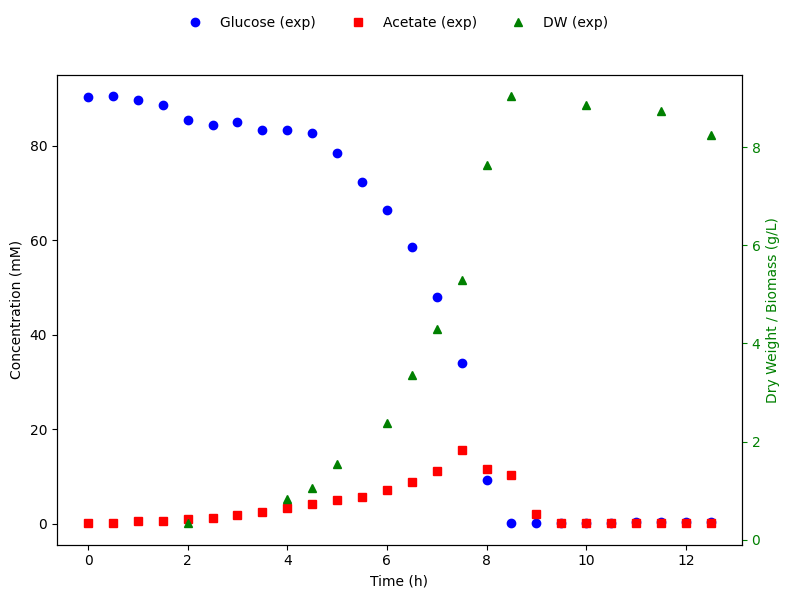

In [26]:
plot_exp(exp_data)

In [16]:
import matplotlib.pyplot as plt

def plot_exp_vs_sim(history, exp_data):
    fig, ax1 = plt.subplots(figsize=(8, 6))

    line1, = ax1.plot(exp_data['Time'], exp_data['Glucose'], 'bo', label='Glucose (exp)')
    line2, = ax1.plot(exp_data['Time'], exp_data['Acetate'], 'rs', label='Acetate (exp)')
    line3, = ax1.plot(history['t'], history['glc'], 'b-', label='Glucose (sim)')
    line4, = ax1.plot(history['t'], history['ac'], 'r-', label='Acetate (sim)')

    ax1.set_xlabel('Time (h)')
    ax1.set_ylabel('Concentration (mM)')


    ax2 = ax1.twinx()
    line5, = ax2.plot(exp_data['Time'], exp_data['DW'], 'g^', label='DW (exp)')
    line6, = ax2.plot(history['t'], history['X'], 'g-', label='Biomass (sim)')
    ax2.set_ylabel('Dry Weight / Biomass (g/L)')

    lines = [line1, line3, line2, line4, line5, line6]
    labels = [l.get_label() for l in lines]
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), 
            ncol=3, frameon=False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

In [17]:
initial_vals = {
    'biomass': exp_data['DW'][exp_data['Time'] == 2].iloc[0],
    'glucose': exp_data['Glucose'][exp_data['Time'] == 2].iloc[0],
    'acetate': exp_data['Acetate'][exp_data['Time'] == 2].iloc[0]
}


--- Starting Leak Sealing Process ---
>> No leaks found. Model is sealed.


/home/dylan33smith/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


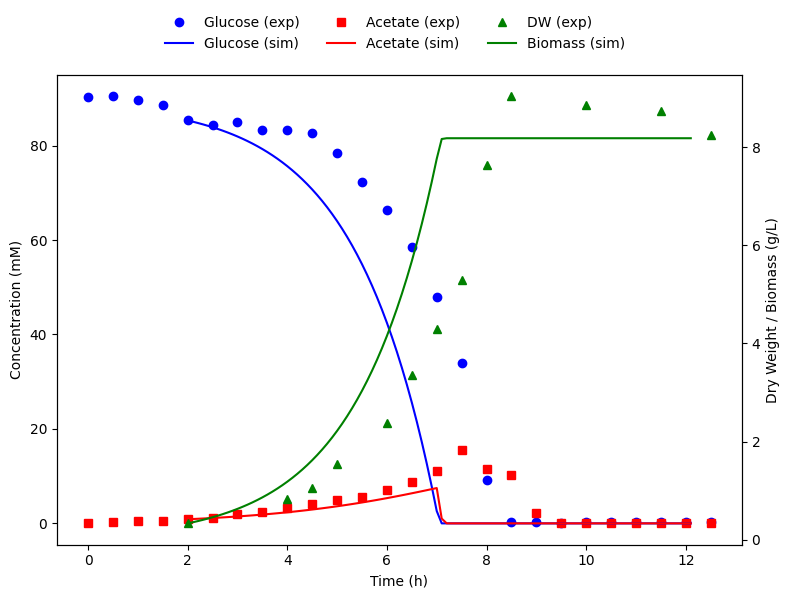

In [18]:
# === ENZYME CONSTRAINED FBA WITH ACETATE FEEDBACK===

params = SimParams(
    ac_feedback = True,
    vmax_ac_ex = 2,
    ac_feedback_k = 13.0,
    ec_constraints = True,
    dt = 0.1
)

try:
    del sim
except NameError:
    pass

sim = dFBA(model_ec, initial_vals, sim_params=params)
sim.initialize_state()
sim.run(12)
hist = sim.print_history
plot_exp_vs_sim(hist, exp_data)

In [19]:
# === ENZYME CONSTRAINED FBA WITHOUT ACETATE FEEDBACK ===
params2 = SimParams(
    ac_feedback = False,
    vmax_ac_ex = 2,
    ac_feedback_k = 13.0,
    ec_constraints = True, # setting to false runs standard FBA
    dt = 0.1
)

try:
    del sim2
except NameError:
    pass

sim2 = dFBA(model_ec, initial_vals, sim_params=params2)
sim2.initialize_state()
sim2.run(12)
hist2 = sim2.print_history



--- Starting Leak Sealing Process ---
>> No leaks found. Model is sealed.


/home/dylan33smith/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [20]:
# === STANDARD FBA WITH ACETATE FEEDBACK ===
params3 = SimParams(
    ac_feedback = True,
    vmax_ac_ex = 2,
    ac_feedback_k = 13.0,
    ec_constraints = False, # setting to false runs standard FBA
    dt = 0.1
)
try:
    del sim3
except NameError:
    pass

sim3 = dFBA(model_ec, initial_vals, sim_params=params3)
sim3.initialize_state()
sim3.run(12)
hist3 = sim3.print_history


--- Starting Leak Sealing Process ---


/home/dylan33smith/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [21]:
# === STANDARD FBA WITHOUT ACETATE FEEDBACK ===
params4 = SimParams(
    ac_feedback = False,
    vmax_ac_ex = 2,
    ac_feedback_k = 13.0,
    ec_constraints = False, # setting to false runs standard FBA
    dt = 0.1
)
try:
    del sim4
except NameError:
    pass

sim4 = dFBA(model_ec, initial_vals, sim_params=params4)
sim4.initialize_state()
sim4.run(12)
hist4 = sim4.print_history


--- Starting Leak Sealing Process ---
>> No leaks found. Model is sealed.


/home/dylan33smith/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [22]:
cond_histories = {}
cond_histories['standard FBA without acetate feedback'] = hist4
cond_histories['standard FBA with acetate feedback'] = hist3
cond_histories['ecFBA without acetate feedback'] = hist2
cond_histories['ecFBA with acetate feedback'] = hist

In [ ]:
def plot_exp_vs_sim_grid(cond_histories, exp_data, save_path=None):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes_flat = axes.flat
    
    legend_lines = []
    legend_labels = []
    
    for idx, ((title, history), ax1) in enumerate(zip(cond_histories.items(), axes_flat)):
        # --- Left axis: Glucose & Acetate ---
        line1, = ax1.plot(exp_data['Time'], exp_data['Glucose'], 'bo', label='Glucose (exp)')
        line2, = ax1.plot(exp_data['Time'], exp_data['Acetate'], 'rs', label='Acetate (exp)')
        line3, = ax1.plot(history['t'], history['glc'], 'b-', label='Glucose (sim)')
        line4, = ax1.plot(history['t'], history['ac'], 'r-', label='Acetate (sim)')
        
        ax2 = ax1.twinx()
        
        line5, = ax2.plot(exp_data['Time'], exp_data['DW'], 'g^', label='DW (exp)')
        line6, = ax2.plot(history['t'], history['X'], 'g-', label='Biomass (sim)')
        
        ax1.set_title(title)
        ax1.set_ylim(0, 150)
        
        if idx >= 2:
            ax1.set_xlabel('Time (h)')
        if idx % 2 == 0:
            ax1.set_ylabel('Concentration (mM)')
        if idx % 2 == 1:
            ax2.set_ylabel('Dry Weight / Biomass (g/L)', color='g')
            ax2.tick_params(axis='y', colors='g')
        
        if idx == 0:
            legend_lines = [line1, line3, line2, line4, line5, line6]
            legend_labels = [l.get_label() for l in legend_lines]
    
    fig.legend(legend_lines, legend_labels, loc='lower center', 
               bbox_to_anchor=(0.5, 0), ncol=6, frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1) 
    
    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight', dpi=150)
    
    plt.show()

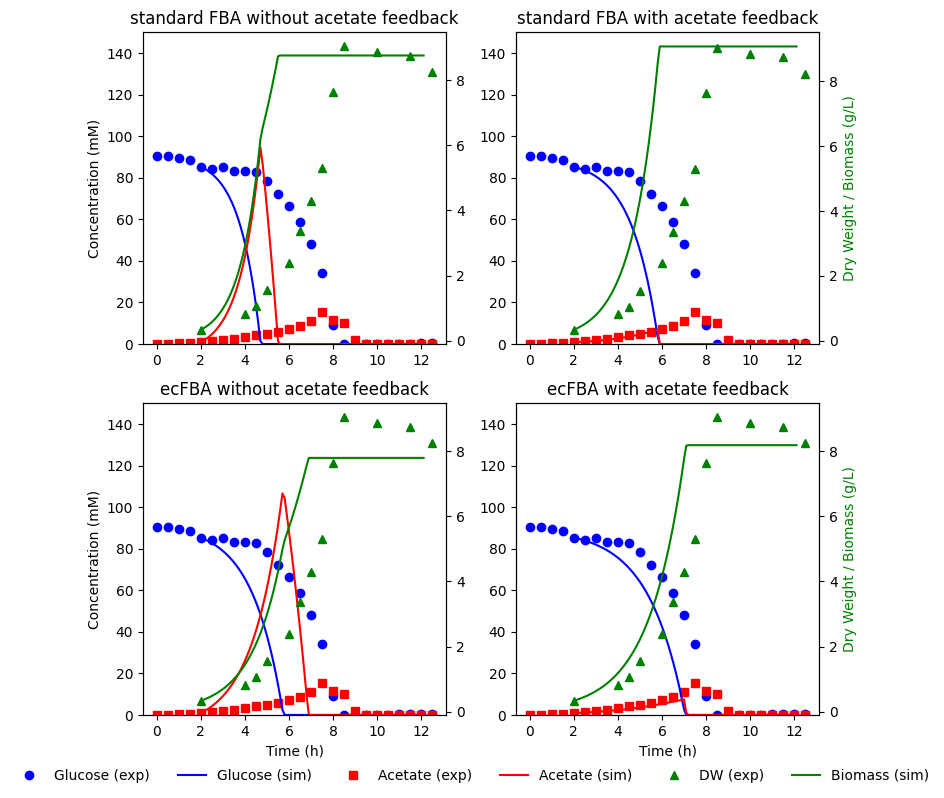

In [24]:
plot_exp_vs_sim_grid(cond_histories, exp_data, save_path='figures/exp_vs_sim_grid.png')

# <img src="figures/exp_vs_sim_KarlsenParams.png" width="600">
The above is a plot of the different simulation conditions (standard FBA, standard FBA with acetate feedback, ecFBA, ecFBA with acetate feedback) using the parameter values from the Karlsen et al paper. 
# <img src="figures/exp_vs_sim_tuned_feedback.png" width="600">


A noticeable deviation from the experimental data is steady value rather than lack of decreasing biomass after all carbon sources have been used up. This is due to a limitation of FBA modeling, where in the absence of any growth carbon sources, the linear optimization becomes infeasible rather than predicting some rate of cell death.


### $O_2$ Sensitivity Analysis 


In genome-scale metabolic modeling, the **Oxygen Uptake Rate (OUR)** is one of the most critical parameters determining the metabolic phenotype of *E. coli*. It defines the limit of the electron transport chain.
* **High $O_2$:** The cell can fully oxidize glucose via the TCA cycle (Respiration). This generates maximum ATP, leading to high biomass yield and low by-product secretion.
* **Low $O_2$:** The cell is forced to ferment glucose to maintain redox balance (NADH/NAD+ ratio), excreting acetate even when glucose is scarce.

Mahadevan et al. (2002) and Karlsen et al. (2023) highlight that accurately estimating $v_{O_2, max}$ is essential for reproducing the "Overflow Metabolism" phenomenon (the accumulation of acetate). In the Karlsen paper (Table 1), the oxygen bound was iteratively tuned down (from 1000 down to 15 mmol/gDW/h) to force the model to secrete acetate matching experimental observations. In my simulations, an $O_2$ level of 15 mmol/gDW/h led to significantly faster uptake of glucose, acetate and biomass accumulation. We will perform a **Parameter Sweep** by varying the maximum oxygen uptake rate from 1 to 15 mmol/gDW/h. For each value, we will simulate the full batch fermentation and analyze:
1.  **Phenotypic Switch:** At what oxygen level does the cell switch from pure respiration to acetate overflow?
2.  **Model Fit:** Which parameter value minimizes the error between the simulation and the specific experimental data provided?

In [ ]:
params = SimParams(
    ac_feedback = True,
    vmax_ac_ex = 2.0,
    ac_feedback_k = 13.0,
    ec_constraints = True,
    dt = 0.1
)

sensitivity_sim = dFBA(model_ec, initial_vals, sim_params=params)

In [ ]:
def run_o2_sweep(sim, o2_values, t_max=12):

    results = {}
    
    for o2_val in o2_values:
        sim.model.reactions.EX_o2_e.lower_bound = -o2_val
        sim.run(t_max)
        results[o2_val] = sim.print_history.copy()
        print(f"Completed O2 = {o2_val}")
    
    return results

In [ ]:
o2_values = list(range(1, 16)) 
all_results = run_o2_sweep(sensitivity_sim, o2_values, t_max=12)

print(f"\nSweep complete! Stored results for {len(all_results)} O2 values.")

Completed O2 = 1
Completed O2 = 2


/home/dylan33smith/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Completed O2 = 3
Completed O2 = 4
Completed O2 = 5
Completed O2 = 6
Completed O2 = 7
Completed O2 = 8
Completed O2 = 9
Completed O2 = 10
Completed O2 = 11
Completed O2 = 12
Completed O2 = 13
Completed O2 = 14
Completed O2 = 15

Sweep complete! Stored results for 15 O2 values.


In [127]:
def plot_overlay_trajectories(results_dict, exp_data):
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    o2_vals = sorted(results_dict.keys())
    norm = mcolors.Normalize(vmin=min(o2_vals), vmax=max(o2_vals))
    cmap = cm.viridis
    
    # Glucose
    ax1 = axes[0]
    ax1.scatter(exp_data['Time'], exp_data['Glucose'], c='black', s=50, 
                label='Experimental', zorder=10, marker='o')
    for o2_val in o2_vals:
        hist = results_dict[o2_val]
        color = cmap(norm(o2_val))
        ax1.plot(hist['t'], hist['glc'], color=color, linewidth=1.5, alpha=0.8)
    ax1.set_xlabel('Time (h)')
    ax1.set_ylabel('Glucose (mM)')
    ax1.set_title('Glucose Concentration')
    ax1.legend(loc='upper right')
    
    # Acetate
    ax2 = axes[1]
    ax2.scatter(exp_data['Time'], exp_data['Acetate'], c='black', s=50, 
                label='Experimental', zorder=10, marker='s')
    for o2_val in o2_vals:
        hist = results_dict[o2_val]
        color = cmap(norm(o2_val))
        ax2.plot(hist['t'], hist['ac'], color=color, linewidth=1.5, alpha=0.8)
    ax2.set_xlabel('Time (h)')
    ax2.set_ylabel('Acetate (mM)')
    ax2.set_title('Acetate Concentration')
    ax2.legend(loc='upper right')
    
    # Biomass
    ax3 = axes[2]
    ax3.scatter(exp_data['Time'], exp_data['DW'], c='black', s=50, 
                label='Experimental', zorder=10, marker='^')
    for o2_val in o2_vals:
        hist = results_dict[o2_val]
        color = cmap(norm(o2_val))
        ax3.plot(hist['t'], hist['X'], color=color, linewidth=1.5, alpha=0.8)
    ax3.set_xlabel('Time (h)')
    ax3.set_ylabel('Biomass (g/L)')
    ax3.set_title('Biomass Concentration')
    ax3.legend(loc='upper left')
    
    plt.subplots_adjust(right=0.88)
    
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, shrink=0.8, pad=0.03)
    cbar.set_label('Max O2 Uptake (mmol/gDW/h)', fontsize=11)
    
    plt.suptitle('O2 Sensitivity', fontsize=14, y=1.02)
    plt.show()

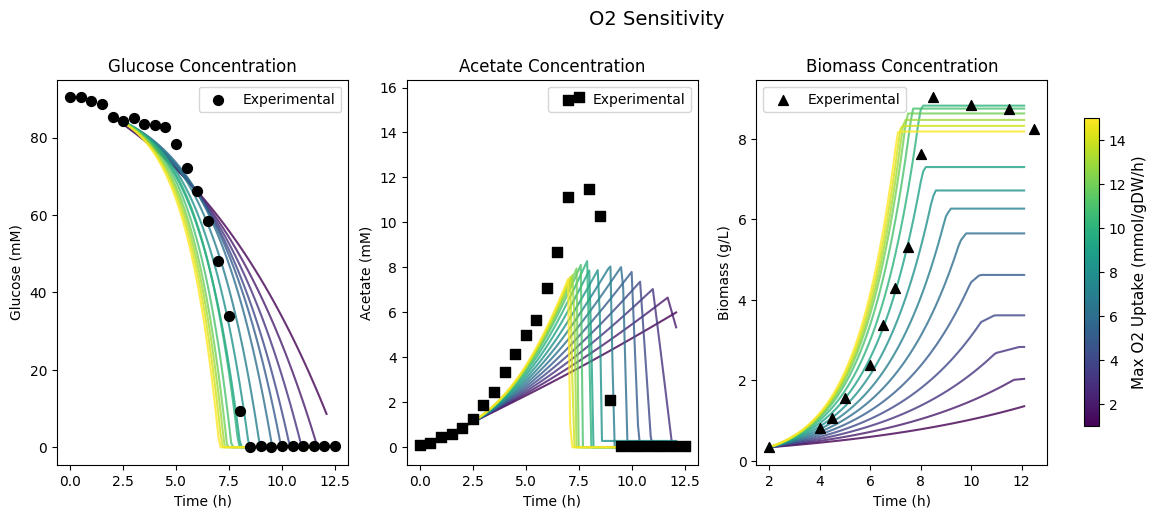

In [126]:
plot_overlay_trajectories(all_results, exp_data)

### Trajectory Overlay
The trajectory plots show the dynamic response of the system as the Oxygen Uptake Rate ($v_{O_2, max}$) is varied from 1 (purple) to 15 (yellow) mmol/gDW/h.

* **Glucose (Left Panel):** Higher oxygen availability leads to steeper consumption slopes. This indicates a faster specific growth rate ($\mu$), allowing the population to consume the available carbon source more quickly. The green lines (Medium $O_2$) align best with the experimental glucose depletion time of ~8 hours.
* **Acetate (Middle Panel):** The timing of the acetate peak shifts significantly at different levels of oxygen. Low oxygen simulations produce a delayed, sluggish acetate peak. High oxygen simulations produce a sharp, early peak that aligns with the moment of glucose depletion, followed by rapid consumption.
* **Biomass (Right Panel):** There is a dramatic separation in final biomass concentration. Low oxygen settings (purple/blue) result in stunted growth (< 2 g/L), indicating the culture is oxygen-limited and forced to rely on inefficient fermentation. As oxygen availability increases (green/yellow), the final biomass plateaus near the experimental maximum (~8.5 g/L).


In [54]:
def extract_sweep_metrics(results_dict, glc_threshold=0.5):
    """
    Extract key outcome metrics from each simulation run.
    
    Parameters:
    -----------
    results_dict : dict
        Output from run_o2_sweep().
    glc_threshold : float
        Glucose concentration below which we consider it "depleted" (default 0.5 mM).
        
    Returns:
    --------
    DataFrame with columns: o2_max, final_biomass, peak_acetate, glc_depletion_time, avg_growth_glucose
    """
    import numpy as np
    
    metrics_list = []
    
    for o2_val, hist in results_dict.items():
        final_biomass = hist['X'].iloc[-1]
        
        peak_acetate = hist['ac'].max()
        
        # Time when glucose depletes 
        glc_depleted = hist[hist['glc'] < glc_threshold]
        if len(glc_depleted) > 0:
            glc_depletion_time = glc_depleted['t'].iloc[0]
        else:
            glc_depletion_time = np.nan  # Glucose never depleted
        
        if not np.isnan(glc_depletion_time):
            glucose_phase = hist[(hist['t'] <= glc_depletion_time) & (hist['growth_rate'] != 'nan')]
        else:
            glucose_phase = hist[hist['growth_rate'] != 'nan']
        
        if len(glucose_phase) > 0:
    
            growth_rates = pd.to_numeric(glucose_phase['growth_rate'], errors='coerce')
            avg_growth_glucose = growth_rates.mean()
        else:
            avg_growth_glucose = np.nan
        
        metrics_list.append({
            'o2_max': o2_val,
            'final_biomass': final_biomass,
            'peak_acetate': peak_acetate,
            'glc_depletion_time': glc_depletion_time,
            'avg_growth_glucose': avg_growth_glucose
        })
    
    return pd.DataFrame(metrics_list).sort_values('o2_max').reset_index(drop=True)

In [ ]:
def plot_sweep_summary(metrics_df, exp_data, glc_threshold=0.5):
    import numpy as np
    
    exp_final_biomass = exp_data['DW'].iloc[-1]
    exp_peak_acetate = exp_data['Acetate'].max()
    
    exp_glc_depleted = exp_data[exp_data['Glucose'] < glc_threshold]
    if len(exp_glc_depleted) > 0:
        exp_glc_depletion_time = exp_glc_depleted['Time'].iloc[0]
    else:
        exp_glc_depletion_time = np.nan
    
    if not np.isnan(exp_glc_depletion_time):
        glucose_phase_exp = exp_data[exp_data['Time'] <= exp_glc_depletion_time]
    else:
        glucose_phase_exp = exp_data
    
    if len(glucose_phase_exp) > 1:
        dw = glucose_phase_exp['DW'].values
        t = glucose_phase_exp['Time'].values
        growth_rates = []
        for i in range(1, len(dw)):
            if dw[i] > 0 and dw[i-1] > 0 and t[i] > t[i-1]:
                mu = np.log(dw[i] / dw[i-1]) / (t[i] - t[i-1])
                growth_rates.append(mu)
        exp_avg_growth = np.mean(growth_rates) if growth_rates else np.nan
    else:
        exp_avg_growth = np.nan
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    o2 = metrics_df['o2_max']
    
    # Final Biomass
    ax1 = axes[0, 0]
    ax1.plot(o2, metrics_df['final_biomass'], 'o-', color='green', linewidth=2, markersize=8)
    ax1.axhline(y=exp_final_biomass, color='black', linestyle='--', linewidth=2, label=f'Exp: {exp_final_biomass:.2f} g/L')
    ax1.set_xlabel('Max O2 Uptake (mmol/gDW/h)')
    ax1.set_ylabel('Final Biomass (g/L)')
    ax1.set_title('Final Biomass vs O2 Availability')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # Peak Acetate
    ax2 = axes[0, 1]
    ax2.plot(o2, metrics_df['peak_acetate'], 's-', color='red', linewidth=2, markersize=8)
    ax2.axhline(y=exp_peak_acetate, color='black', linestyle='--', linewidth=2, label=f'Exp: {exp_peak_acetate:.2f} mM')
    ax2.set_xlabel('Max O2 Uptake (mmol/gDW/h)')
    ax2.set_ylabel('Peak Acetate (mM)')
    ax2.set_title('Peak Acetate vs O2 Availability')
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3)
    
    # Glucose Depletion Time
    ax3 = axes[1, 0]
    ax3.plot(o2, metrics_df['glc_depletion_time'], '^-', color='blue', linewidth=2, markersize=8)
    if not np.isnan(exp_glc_depletion_time):
        ax3.axhline(y=exp_glc_depletion_time, color='black', linestyle='--', linewidth=2, label=f'Exp: {exp_glc_depletion_time:.1f} h')
        ax3.legend(loc='upper right')
    ax3.set_xlabel('Max O2 Uptake (mmol/gDW/h)')
    ax3.set_ylabel('Time to Glucose Depletion (h)')
    ax3.set_title('Glucose Depletion Time vs O2 Availability')
    ax3.grid(True, alpha=0.3)
    
    # Average Growth Rate (Glucose Phase)
    ax4 = axes[1, 1]
    ax4.plot(o2, metrics_df['avg_growth_glucose'], 'd-', color='purple', linewidth=2, markersize=8)
    if not np.isnan(exp_avg_growth):
        ax4.axhline(y=exp_avg_growth, color='black', linestyle='--', linewidth=2, label=f'Exp: {exp_avg_growth:.3f} 1/h')
        ax4.legend(loc='lower right')
    ax4.set_xlabel('Max O2 Uptake (mmol/gDW/h)')
    ax4.set_ylabel('Avg Growth Rate (1/h)')
    ax4.set_title('Average Growth Rate (Glucose Phase) vs O2')
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('O2 Sensitivity Analysis: Summary Metrics', fontsize=14)
    plt.tight_layout()
    plt.show()

In [56]:
metrics_df = extract_sweep_metrics(all_results, glc_threshold=0.5)
print("Summary Metrics for O2 Sensitivity Sweep:")
print("=" * 70)
display(metrics_df)

Summary Metrics for O2 Sensitivity Sweep:


,o2_max,final_biomass,peak_acetate,glc_depletion_time,avg_growth_glucose
0,1,1.354704,5.995386,NaN,0.138042
1,2,2.034627,6.655982,11.7,0.184450
2,3,2.827151,7.035922,11.0,0.230704
3,4,3.613677,7.363082,10.4,0.277232
4,5,4.617128,7.796160,10.0,0.322575
5,6,5.649091,8.012379,9.6,0.367430
6,7,6.265032,8.038132,9.0,0.413436
7,8,6.715738,7.876787,8.5,0.457589
8,9,7.297700,7.863608,8.1,0.502156
9,10,8.823591,8.277044,8.0,0.542776


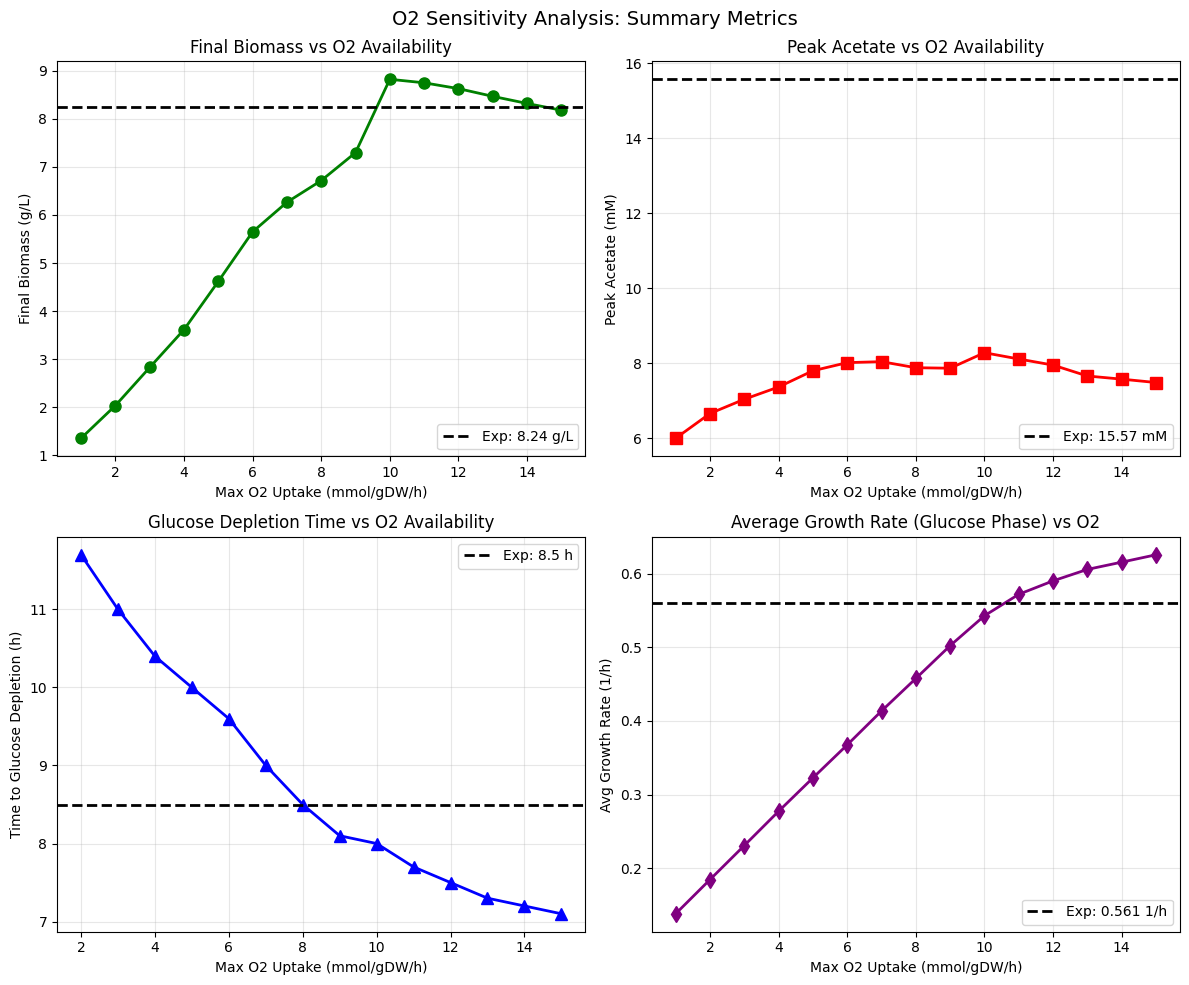

In [57]:
plot_sweep_summary(metrics_df, exp_data, glc_threshold=0.5)

### Summary Metrics
The dose-response curves allow us to identify the specific parameter value that best fits the experimental data (represented by the black dashed lines).

* **Final Biomass vs. $O_2$:** The model shows a linear increase in biomass yield until decreasing after 10 mmol/gDW/h. The simulation curve intersects the experimental average (8.24 g/L) at **$v_{O_2, max} \approx 9$ mmol/gDW/h**. 
* **Peak Acetate Discrepancy:** While the model captures the timing of the acetate peak, it consistently **underpredicts the magnitude** (Simulated ~8 mM vs. Experimental ~15 mM). This suggests that while $O_2$ constraints contribute to the *timing* of the switch, discrepencies in the model setup don't capture the flux of carbon into acetate at Karlsens defined parameters. 
* **Glucose Depletion Time:** The time to deplete glucose decreases as oxygen increases. The experimental time (8.5 h) is achieved when **$v_{O_2, max} \approx 8$ mmol/gDW/h**.
* **Average Growth Rate:** The experimental growth rate (0.56 $h^{-1}$) intersects the simulation curve at **$v_{O_2, max} \approx 11$ mmol/gDW/h**, just as the growth rate begins to decrease and leave the linear phase.

A value of **$v_{O_2, max} = 10.0$ mmol/gDW/h** serves as the best global fit, balancing the trade-offs between growth speed and biomass yield. This is $\frac{2}{3}$ of the $O_2$ parameter determined by the Karlsen paper to fit the same experimental data. This is likely due to differences in how I handled excretion of certain metabolites. I zeroed out all metabolites in the medium that weren't included in the experimental data, as a significant portion of carbon flux was being rerouted through those pathways. This improved the simulation as it constrained it closer to the experimental values, but it was a broad approach that likely removed some of the nuance in the carbon flows that was present in the Karlsen model. 